<h1>Photon Diffusion</h1>
<h3>Calculates the diffusion of photons in a non-absorbing medium (lanex phosphor) using Fick's laws of diffusion.</h3>

In [1]:
#Imports
from numpy import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erf
import sys
import os

#Import custom modules
sys.path.append('/home/drake/Documents/Physics/Research/Python/Modules')
from physics import *

%matplotlib notebook

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 12 days


<h3>Calculation of the phosphor layer thickness of lanex regular given its areal density:</h3>

In [3]:
Dcell = 55*10**-6
DPET = 175*10**-6
Dcell2 = 13*10**-6
rhocell = 1.44*10**3
rhoPET = 1.38*10**3
rhophos = 4.48*10**3
sigma = 70*10**-2

Dphos = (sigma - Dcell*rhocell - DPET*rhoPET - Dcell2*rhocell)/rhophos
print(Dphos*10**6)

80.48660714285715


<h3>Define functions for photon density and photon current density</h3>
<font size="4"><p>These functions were derived from Fick's laws of diffusion:

$$ \frac{\partial n(z,t)}{\partial t} = D \frac{\partial^2 n(z,t)}{\partial z^2}, \: \: \phi (z,t) = -D \frac{\partial n(z,t)}{\partial z}$$

where n(z,t) is the photon density, D is the diffusion constant $D=\lambda_s c /6$ with $\lambda_s$ corresponding to the mean photon scattering length, and $\phi (z,t)$ is the photon current density. The fluorescence of the lanex phosphor was modeled as the instantaneous generation of light within a infinitely thin segment within a rectangular slab. The slab thickness $L$ is taken to be small compared to the other dimensions so that the problem can be treated one-dimensionally. The initial condition is taken to be

$$ n(z,0) = \frac{N_0}{A} \delta (z) \: \: \mathrm{with} \: \: n(z,t)=0 \: \: \mathrm{for} \: t<0 $$

where $N_0$ is the number of photons generated and $A$ is the cross-sectional area of the slab. In other words, at $t=0$, $N_0$ photons are generated and modeled as a dirac delta function at $z=0$. Fick's laws are then solved with absorbing boundary conditions at the edges of the lanex:

$$ n(d,t)=0, \: n(-l,t)=0$$

where $z=d$ is the location of the CCD and $z=-l$ is the location of the top edge of the phosphor. This yields

$$ n(z,t) = \frac{N_0}{2 A \sqrt{\pi D t}} \sum\limits_{m=-\infty}^\infty \left[ e^{-(z-2mL)^2/4Dt} - e^{-(z+2mL-2d)^2/4Dt} \right] $$

The photon current density then follows by differentiation with respect to $z$.

</font></p>

In [4]:
N0 = 10**6 #Number of photons emitted at t=0
lambdas = 2.85*10**-6 #Diffusion length in m
D = lambdas*c/6 #Diffusion constant
A = 100*10**-6*100*10**-6 #Area of segment in m^2
L = 81*10**-6 #Depth of lanex in m
l = 10.0*10**-6 #Distance from top lanex edge to segment in m
d = L-l #Distance from bottom lanex edge to segment

def n(z,t):
    '''Returns the photon density at position z and time t'''
    n0 = N0/(2*A*sqrt(pi*D*t))
    Sum = 0
    maxm = 10
    for m in range(-maxm,maxm+1):
        Sum += exp(-(z-2*m*(l+d))**2/(4*D*t))-exp(-(z+2*m*(l+d)-2*d)**2/(4*D*t))
    return n0*Sum

def particlecurrent(t):
    '''Returns the particle current (photons per second per meter^2) at the boundary z=d at time t'''
    Sum = 0
    maxm = 10
    for m in range(-maxm,maxm+1):
        am = d-2*m*L
        Sum += am*exp(-am**2/(4*D*t))
    return N0/(A*sqrt(4*pi*D*t**3))*Sum

<h3>Plot photon density</h3>
<font size="4"><p>The function $n(z,t)$ is calculated from 1 fs to 10 ps and plotted below. The boundary conditions are visibly satisfied and the function approaches a dirac delta function for short times. It then spreads out with the total number of photons decreasing as they're absorbed at the boundaries.</font></p>

In [5]:
narray = []
zarray = np.linspace(-l,d,1000)
time = [1,10,10**2,10**3,10**4]
time = np.multiply(time,10**-15) #convert to s

for i in range(len(time)):
    narray.append([])
    for z in zarray:
        narray[i].append(n(z,time[i])*10**-6)

zarray = np.multiply(zarray,10**6)

<IPython.core.display.Javascript object>


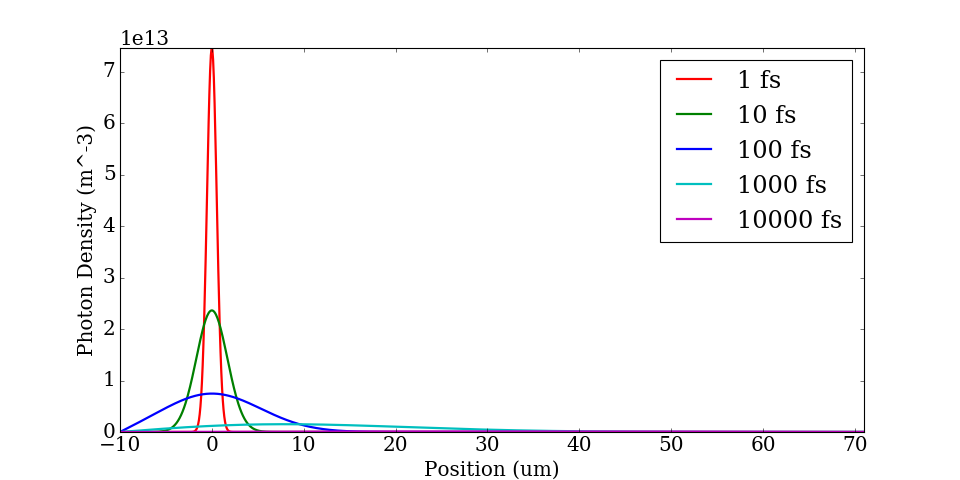

In [6]:
#Update the matplotlib configuration parameters
mpl.rcParams.update({'font.size': 18, 'font.family': 'serif'})

#Adjust figure size
plt.subplots(figsize=(12,6))

color = ['r','g','b','c','m','y','k']
legend = []
for i in range(5):
    legend.append(str(int(time[i]*10**15))+' fs')
    plt.plot(zarray,narray[i],color=color[i],linewidth=2,label=legend[i])
plt.xlim(np.min(zarray),np.max(zarray))
plt.ylim(1.0*10**6,np.max(narray[0]))
plt.xlabel('Position (um)')
plt.ylabel('Photon Density (m^-3)')
#plt.semilogy()
plt.legend(loc=1)

<h3>Plot photon current density</h3>
<font size="4"><p>Photon current density is then calculated at $z=d$ and plotted below as a function of time.</font></p>

In [7]:
particlecurrentarray = []
tarray = []
for t in linspace(10**-15,50*10**-12,1000):
    tarray.append(t*10**12)
    particlecurrentarray.append(particlecurrent(t))

<IPython.core.display.Javascript object>


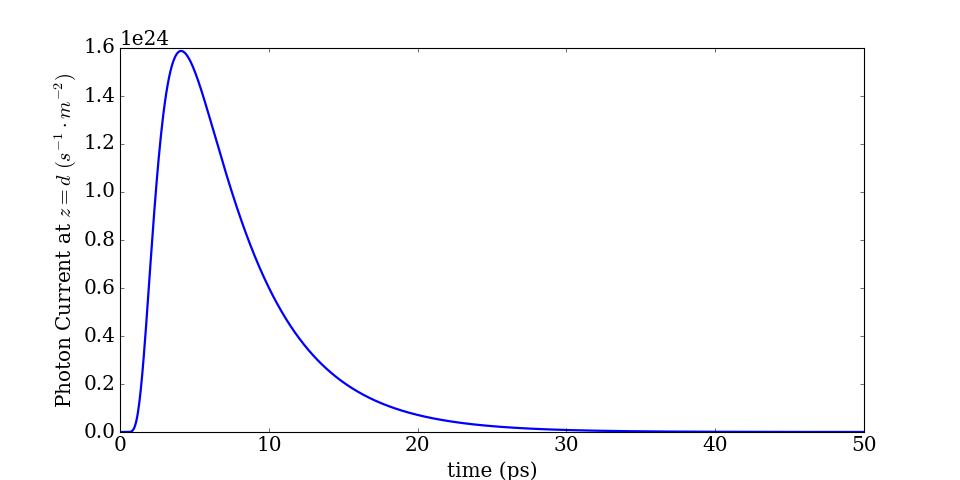

/home/drake/.anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [8]:
#Update the matplotlib configuration parameters
mpl.rcParams.update({'font.size': 18, 'font.family': 'serif'})

#Adjust figure size
plt.subplots(figsize=(12,6))

plt.plot(tarray,particlecurrentarray,linewidth=2)
plt.xlim(np.min(tarray),np.max(tarray))
plt.ylim(0)
plt.xlabel('time (ps)')
plt.ylabel('Photon Current at $z=d$ $(s^{-1} \cdot m^{-2})$')
#plt.semilogy()
plt.legend(loc=4)

<h3>Integrate photon current density</h3>
<font size="4"><p>The photon current density at $z=d$ is then integrated over large times and multiplied by the area $A$ to determine the total number of photons absorbed by the CCD. This is done numerically and analytically with the function defined below. A plot of the fraction of photons absorbed is plotted as a function of time to ensure that the integral converges.</font></p>

In [10]:
Nabs = A*quad(particlecurrent,0,400*10**-12)[0] #Total number of photons absorbed at the boundary z=d
print(Nabs/N0)

0.12345717727032615


In [11]:
def F(t,maxm,distance):
    Sum1 = 0
    Sum2 = 0
    for m in range(-maxm,1):
        am = distance-2*m*L
        Sum1 += 1 - erf(am/sqrt(4*D*t))
    for m in range(1,maxm+1):
        am = distance-2*m*L
        Sum2 += 1 + erf(am/sqrt(4*D*t))
    return (Sum1 - Sum2)

In [12]:
FractionAbsArray = []
FractionAbsArrayAnalytic = []
tarray = []
for t in linspace(10**-12,50*10**-12,10000):
    tarray.append(t*10**12)
    #FractionAbsArray.append(A*quad(particlecurrent,0,t)[0]/N0)
    FractionAbsArrayAnalytic.append(F(t,100,d))

<IPython.core.display.Javascript object>


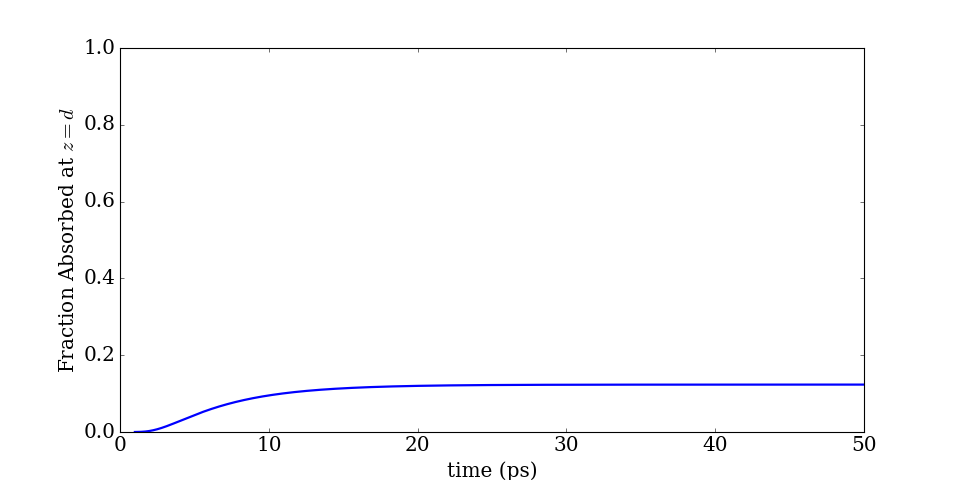

/home/drake/.anaconda3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [14]:
#Adjust figure size
plt.subplots(figsize=(12,6))

plt.plot(tarray,FractionAbsArrayAnalytic,linewidth=2)
plt.xlim(np.min(tarray),np.max(tarray))
plt.ylim(0,1.0)
plt.xlim(0,50)
plt.xlabel('time (ps)')
plt.ylabel('Fraction Absorbed at $z=d$')
#plt.semilogy()
plt.legend(loc=4)

<h3>Calculate number of photons absorbed as a function of d</h3>
<font size="4"><p>A function is defined to calculate the total number of photons absorbed at $z=d$ after all time as a function of $d$. The results are then plotted and found to be linear. The rather unpleasant expression defined above evidently can be approximated as (or is exactly equal to)

$$N_{abs}(d) = N_0 (1 - d/L) $$
</font></p>

In [15]:
FractionAbsArrayAnalytic = []
distancearray = []

#Find the fraction of photons absorbed at z=d for various values of d ranging from 0 to L - 1 um (to avoid division by zero errors)
for distance in linspace(0,L-10**-6,100):
    Integrationtime = 10**-12
    TargetError = 10**-3
    Error = 1.0
    FractionAbsAnalytic=0
    while Error>TargetError:
        Error = abs(FractionAbsAnalytic-F(Integrationtime,100,distance))/F(Integrationtime,100,distance)
        FractionAbsAnalytic = F(Integrationtime,100,distance)
        Integrationtime *= 2
    FractionAbsArrayAnalytic.append(FractionAbsAnalytic)
    distancearray.append(distance*10**6)

<IPython.core.display.Javascript object>


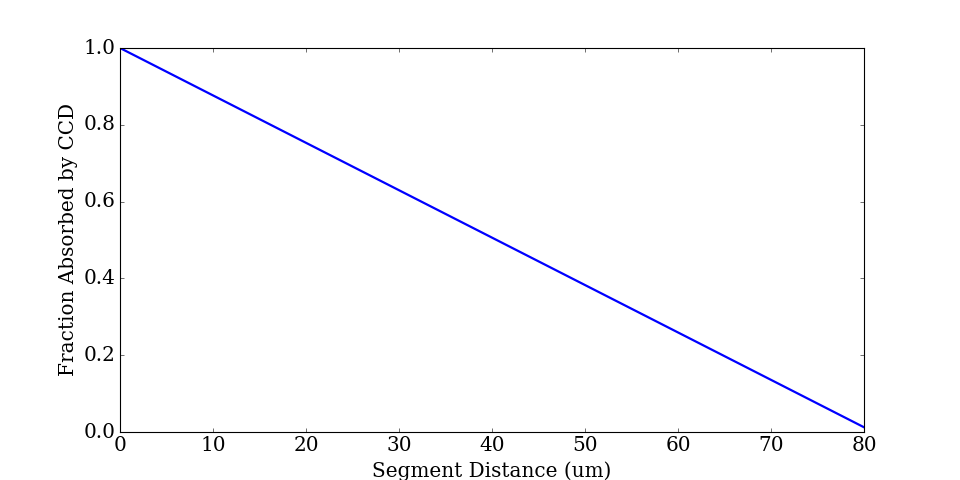

In [18]:
#Update the matplotlib configuration parameters
mpl.rcParams.update({'font.size': 18, 'font.family': 'serif'})

#Adjust figure size
plt.subplots(figsize=(12,6))

plt.plot(distancearray,FractionAbsArrayAnalytic,linewidth=2)
#plt.xlim(np.min(tarray),np.max(tarray))
#plt.ylim(0,1.0)
#plt.xlim(0,50)
plt.xlabel('Segment Distance (um)')
plt.ylabel('Fraction Absorbed by CCD')
#plt.semilogy()